# IMPORT PACKAGES
All package that are imported for the solution of the problem

In [1]:
import random
import torch
import torchaudio
from torchaudio import transforms
from google.colab import drive

#UTILS SOUND
Important static class that contains all methods for the sound:
*   *open(audio_file)*: given the audio file, it is loaded and read, then returns the signal as a tensor and the sample rate.
*   *rechannel(aud, new_channel)*: converts all types of sounds (mono with 1 audio channel and stereo with 2 audio channels) in the same dimensions, duplicating the first channel to the second.
*   *resample(aud, newsr)*: standardize and convert all audio in the same sampling rate (because a few of them have a sample rate of 48kHz, and the others have a sample rate of 44.1kHz, 1 second of audio have an array dimension of 48k or 44.1k) to have the same dimension.
*   *pad_trunc(aud, max_ms)*: resize all audio samples with the same length (adding silence or truncating it) with a fixed value of milliseconds.
*   *time_shift(aud, shift_limit)*: apply a data augmentation on raw audio signal applying a time shift with a random value.
*   *spectro_gram(aud, n_mels, n_fft, hop_len)*: generate a Mel Spectrogram from an augmented audio; a Mel Spectrogram is the most suitable way to insert audio data in deep learning models.
*   *spectro_augment(spec, max_mask_pct, n_freq_masks, n_time_masks)*: augment the Mel Spectrogram using a technique called SpecAugment, that use the method of frequency mask (randomly mask out a range of consecutive frequencies by adding horizontal bars on spectrogram) and time mask (similar to previous, except randomly block out ranges of time from spectrogram by using vertical bars).
*   *getSpectrogramFromSound(sound_path, sr, channel, duration, shift_pct)*: from a path of sound, get the spectrogram image of the sound, using the sample rate, the number of channels, the duration of the sound and the shift of the sound.

In [2]:
class SoundUtils():
  
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud
    if (sig.shape[0] == new_channel):
      return aud
    if (new_channel == 1):
      resig = sig[:1, :]
    else:
      resig = torch.cat([sig, sig])
    return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud
    if (sr == newsr):
      return aud
    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])
    return ((resig, newsr))

  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
      sig = torch.cat((pad_begin, sig, pad_end), 1)
    return (sig, sr)

  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

  @staticmethod
  def getSpectrogramFromSound(sound_path, sr, channel, duration, shift_pct):
    sound = SoundUtils.open(sound_path)
    sound = SoundUtils.resample(sound, sr)
    sound = SoundUtils.rechannel(sound, channel)
    sound = SoundUtils.pad_trunc(sound, duration)
    sound = SoundUtils.time_shift(sound, shift_pct)
    sound = SoundUtils.spectro_gram(sound, n_mels=64, n_fft=1024, hop_len=None)
    sound = SoundUtils.spectro_augment(sound, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    return sound

  @staticmethod
  def getSpectrogramFromSoundAndSampleRate(sound, sr, channel, duration, shift_pct):
    sound = SoundUtils.resample(sound, sr)
    sound = SoundUtils.rechannel(sound, channel)
    sound = SoundUtils.pad_trunc(sound, duration)
    sound = SoundUtils.time_shift(sound, shift_pct)
    sound = SoundUtils.spectro_gram(sound, n_mels=64, n_fft=1024, hop_len=None)
    sound = SoundUtils.spectro_augment(sound, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    return sound

In [3]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
!pip install boto3

import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

     |████████████████████████████████| 132 kB 9.3 MB/s 
     |████████████████████████████████| 8.6 MB 40.5 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 138 kB 44.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# MOUNT GDRIVE
Mount gdrive to connect to local folders/files

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#EXAMPLES OF USING SOUNDUTILS

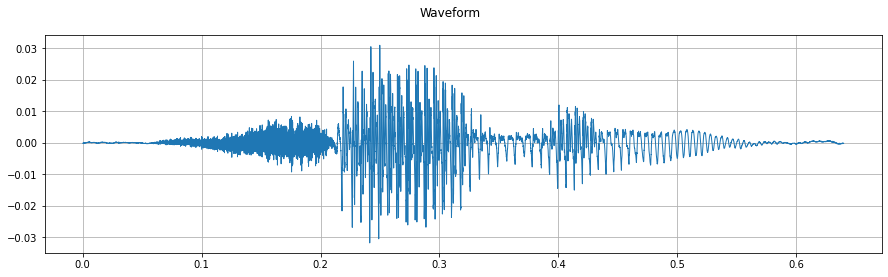

In [5]:
sound = SoundUtils.open("gdrive/My Drive/Colab Notebooks/RECORDINGS/01/7_01_0.wav")
sig, sr = sound
plot_waveform(sig, sr)
play_audio(sig, sr)

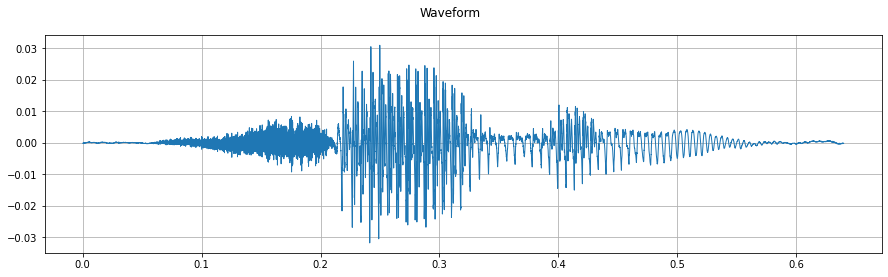

In [6]:
sound = SoundUtils.resample(sound, 48000)
sig, sr = sound
plot_waveform(sig, sr)
play_audio(sig, sr)

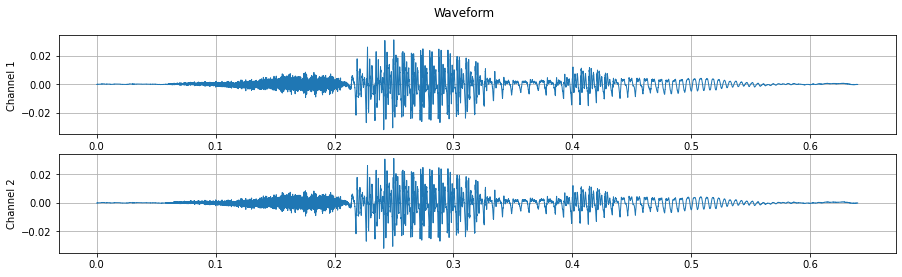

In [7]:
sound = SoundUtils.rechannel(sound, 2)
sig, sr = sound
plot_waveform(sig, sr)
play_audio(sig, sr)

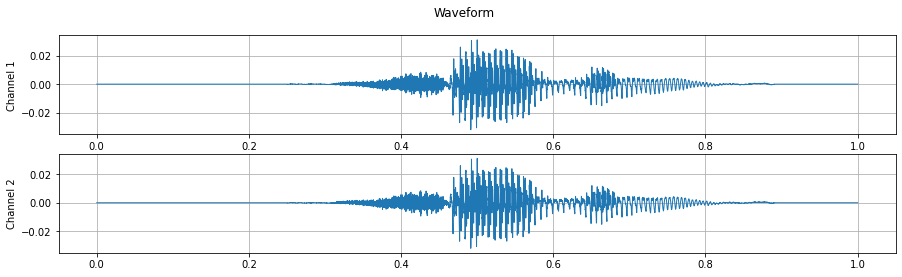

In [8]:
sound = SoundUtils.pad_trunc(sound, 1000)
sig, sr = sound
plot_waveform(sig, sr)
play_audio(sig, sr)

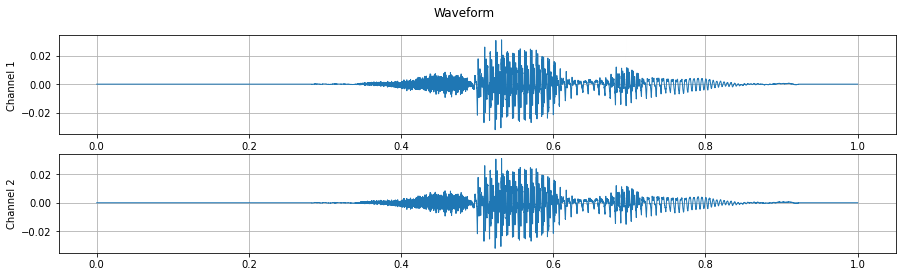

In [9]:
sound = SoundUtils.time_shift(sound, 0.2)
sig, sr = sound
plot_waveform(sig, sr)
play_audio(sig, sr)

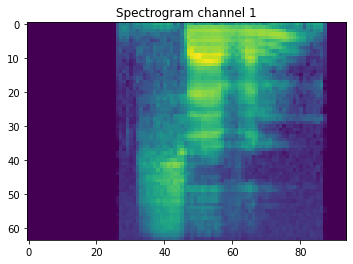

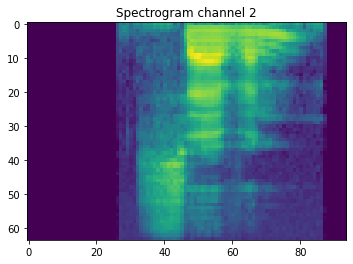

In [10]:
sound = SoundUtils.spectro_gram(sound, n_mels=64, n_fft=1024, hop_len=None)
plt.title("Spectrogram channel 1")
plt.imshow(sound[0])
plt.show()
plt.title("Spectrogram channel 2")
plt.imshow(sound[1])
plt.show()

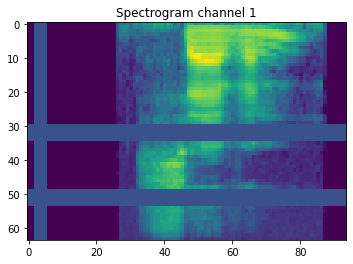

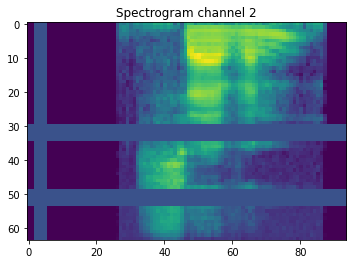

In [11]:
sound = SoundUtils.spectro_augment(sound, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
plt.title("Spectrogram channel 1")
plt.imshow(sound[0])
plt.show()
plt.title("Spectrogram channel 2")
plt.imshow(sound[1])
plt.show()